# Código-fonte do artigo:
> # **Uma Avaliação entre Privacidade e Acurácia em Modelos de Aprendizado Supervisionado em Deep Learning com DP-SGD (_Differentially Private Stochastic Gradient Descent_)**
> ### @Autores: Gustavo Gobi Martinelli (gustavomartinelli@gmail.com), Rodolfo da Silva Villaça (rodolfo.villaca@inf.ufes.br)


#**1) Instala a biblioteca Opacus.**

O Google Colab não possui essa biblioteca nativamente.

In [1]:
!pip install opacus -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 10.0 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_

# **2) Carregamento do CIFAR-10 e criação dos *dataloaders*.**

Este trecho baixa o CIFAR-10, aplica transformação para tensores, cria *dataloaders* para treino e teste, e seleciona o dispositivo (*CPU* ou *GPU*).


In [2]:
import torch, numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train, batch_size=64, shuffle=True, num_workers=0)
test_loader  = DataLoader(test, batch_size=64, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


100%|██████████| 170M/170M [00:07<00:00, 22.3MB/s]


# **3) Definição da CNN com normalização e função de avaliação.**

Este trecho implementa a arquitetura `DPCNN` (camadas convolucionais, *GroupNorm*, *ReLU*, *pooling* e classificadores lineares) e a função `eval_dp`, que calcula a acurácia do modelo no conjunto de teste.


In [4]:
import torch.nn as nn

class DPCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1),
            nn.GroupNorm(4,32),
            nn.ReLU(),

            nn.Conv2d(32,64,3,padding=1),
            nn.GroupNorm(4,64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128,3,padding=1),
            nn.GroupNorm(8,128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(8*8*128,256),
            nn.ReLU(),

            nn.Linear(256,num_classes)
        )

    def forward(self, x):
        return self.net(x)

def eval_dp(model):
    model.eval()
    correct=0; total=0
    for xb,yb in test_loader:
        xb,yb = xb.to(device), yb.to(device)
        pred = model(xb).argmax(1)
        correct += (pred==yb).sum().item()
        total += yb.size(0)
    return correct/total


# **4) Treinamento com *DP-SGD*, coleta de métricas e comparação entre níveis de ruído.**

Este trecho executa três cenários de *Differential Privacy* usando o *PrivacyEngine* (*Privacidade Fraca, Média e Forte*), treina o modelo com *DP-SGD*, calcula perda, acurácia, ε (*epsilon*), gera matrizes de confusão e armazena tudo no dicionário `history` para análises posteriores.


In [ ]:
from opacus import PrivacyEngine
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import torch.nn as nn

# Armazenamento para análises
history = {
    "cenario": [],
    "noise": [],
    "epoch_loss": [],
    "epoch_acc": [],
    "epoch_eps": [],
    "conf_matrix": []
}

configs = [
    ("Privacidade Fraca", 0.3),
    ("Privacidade Média", 0.8),
    ("Privacidade Forte", 1.5),
]

EPOCHS = 3
DELTA = 1e-5

def get_conf_matrix(model):
    all_preds = []
    all_labels = []
    model.eval()
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())
    return confusion_matrix(all_labels, all_preds)

for name, noise in configs:

    model = DPCNN().to(device)
    optim = torch.optim.SGD(model.parameters(), lr=0.1)
    privacy_engine = PrivacyEngine()

    model, optim, train_priv = privacy_engine.make_private(
        module=model,
        optimizer=optim,
        data_loader=train_loader,
        noise_multiplier=noise,
        max_grad_norm=1.0
    )

    epoch_losses = []
    epoch_accs = []
    epoch_eps = []

    for epoch in range(EPOCHS):

        model.train()
        running_loss = 0
        count = 0

        for xb, yb in train_priv:
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad()

            loss = nn.CrossEntropyLoss()(model(xb), yb)
            loss.backward()
            optim.step()

            running_loss += loss.item()
            count += 1

        avg_loss = running_loss / count
        acc = eval_dp(model)
        eps = privacy_engine.get_epsilon(DELTA)

        epoch_losses.append(avg_loss)
        epoch_accs.append(acc)
        epoch_eps.append(eps)

        print(f"{name} | Epoch {epoch+1}/{EPOCHS} | loss={avg_loss:.4f} | acc={acc:.4f} | eps={eps:.2f}")

    # Matriz de confusão ao final do cenário
    cm = get_conf_matrix(model)

    # Armazenar resultados
    history["cenario"].append(name)
    history["noise"].append(noise)
    history["epoch_loss"].append(epoch_losses)
    history["epoch_acc"].append(epoch_accs)
    history["epoch_eps"].append(epoch_eps)
    history["conf_matrix"].append(cm)

print("Treinamento dos 3 cenários finalizado.")


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Privacidade Fraca | Epoch 1/3 | loss=1.7701 | acc=0.4511 | eps=18.97
Privacidade Fraca | Epoch 2/3 | loss=1.5979 | acc=0.4900 | eps=23.41
Privacidade Fraca | Epoch 3/3 | loss=1.6130 | acc=0.4995 | eps=26.90


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Privacidade Média | Epoch 1/3 | loss=2.0136 | acc=0.3212 | eps=0.38
Privacidade Média | Epoch 2/3 | loss=1.8936 | acc=0.3674 | eps=0.48
Privacidade Média | Epoch 3/3 | loss=1.9477 | acc=0.4000 | eps=0.55


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Privacidade Forte | Epoch 1/3 | loss=2.1458 | acc=0.2631 | eps=0.10
Privacidade Forte | Epoch 2/3 | loss=2.3594 | acc=0.2325 | eps=0.13
Privacidade Forte | Epoch 3/3 | loss=2.4761 | acc=0.2920 | eps=0.16
Treinamento dos 3 cenários finalizado.


# **5) Consolidação dos resultados finais em um DataFrame.**

Este trecho cria um `DataFrame` contendo o cenário, o nível de ruído, e as métricas finais de *loss*, acurácia e *epsilon*, permitindo comparar facilmente os efeitos da *privacy*.


In [ ]:
import pandas as pd

df_results = pd.DataFrame({
    "Cenario": history["cenario"],
    "NoiseMultiplier": history["noise"],
    "Epsilon_Final": [eps_list[-1] for eps_list in history["epoch_eps"]],
    "Acuracia_Final": [acc_list[-1] for acc_list in history["epoch_acc"]],
    "Loss_Final": [loss_list[-1] for loss_list in history["epoch_loss"]]
})

df_results


,Cenario,NoiseMultiplier,Epsilon_Final,Acuracia_Final,Loss_Final
0,Privacidade Fraca,0.3,26.895783,0.4995,1.612989
1,Privacidade Média,0.8,0.553284,0.4000,1.947691
2,Privacidade Forte,1.5,0.162141,0.2920,2.476144


# **6) Gráfico da curva de perda por época para cada cenário de *privacy*.**

Este trecho plota a evolução do *loss* ao longo das épocas para cada nível de ruído aplicado no *DP-SGD*, permitindo visualizar como a privacidade afeta a convergência do modelo.


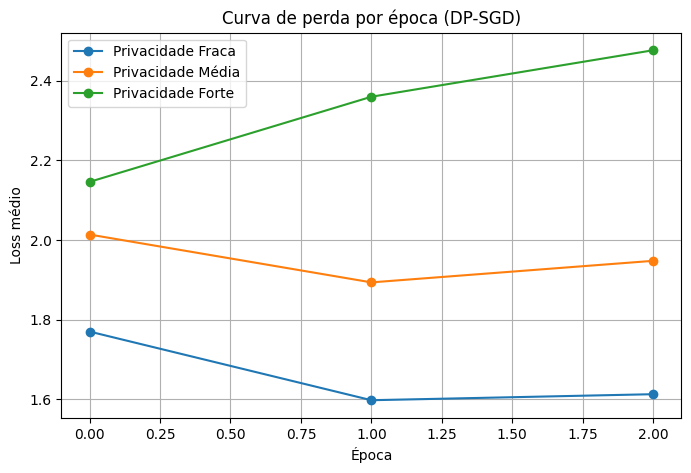

In [ ]:
plt.figure(figsize=(8,5))
for i, name in enumerate(history["cenario"]):
    plt.plot(history["epoch_loss"][i], marker="o", label=name)

plt.xlabel("Época")
plt.ylabel("Loss médio")
plt.title("Curva de perda por época (DP-SGD)")
plt.legend()
plt.grid()
plt.show()


# **7) Gráfico da curva de acurácia por época para cada cenário de *privacy*.**

Este trecho plota a evolução da acurácia ao longo das épocas para cada nível de ruído aplicado, permitindo comparar o impacto da *privacy* na performance do modelo.


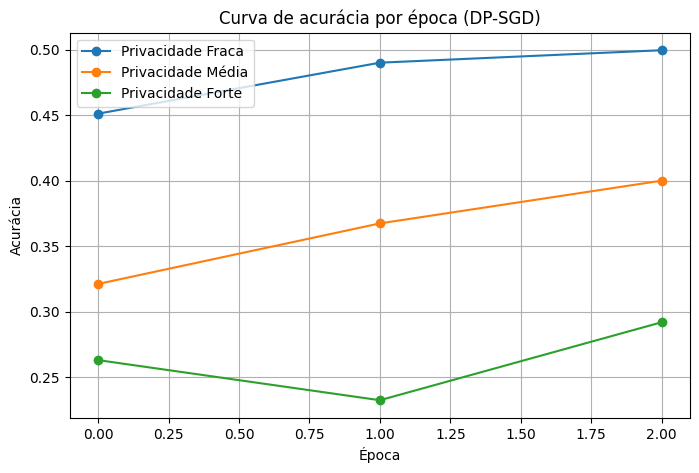

In [ ]:
plt.figure(figsize=(8,5))
for i, name in enumerate(history["cenario"]):
    plt.plot(history["epoch_acc"][i], marker="o", label=name)

plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Curva de acurácia por época (DP-SGD)")
plt.legend()
plt.grid()
plt.show()


# **8) Gráfico da evolução do *epsilon* por época nos cenários com *privacy*.**

Este trecho exibe como o valor de ε evolui durante o treinamento em cada cenário de ruído, ilustrando o custo acumulado de privacidade ao longo das épocas.


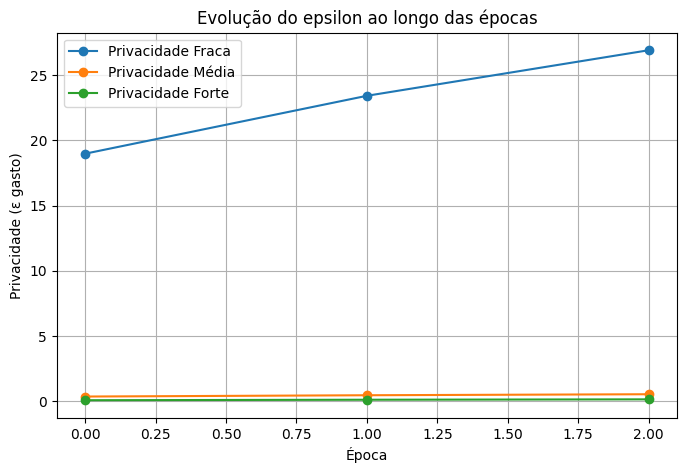

In [ ]:
plt.figure(figsize=(8,5))
for i, name in enumerate(history["cenario"]):
    plt.plot(history["epoch_eps"][i], marker="o", label=name)

plt.xlabel("Época")
plt.ylabel("Privacidade (ε gasto)")
plt.title("Evolução do epsilon ao longo das épocas")
plt.legend()
plt.grid()
plt.show()


# **9) Exibição das matrizes de confusão para cada cenário de *privacy*.**

Este trecho gera *heatmaps* das matrizes de confusão correspondentes a cada nível de ruído, permitindo avaliar visualmente o padrão de erros do modelo em cada cenário.


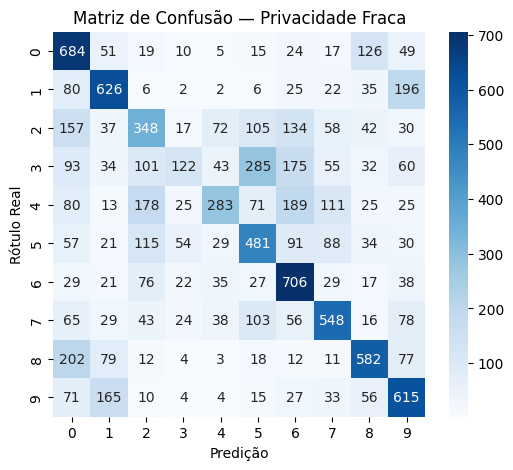

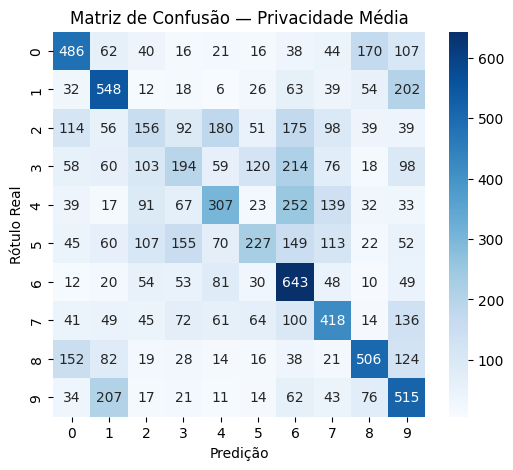

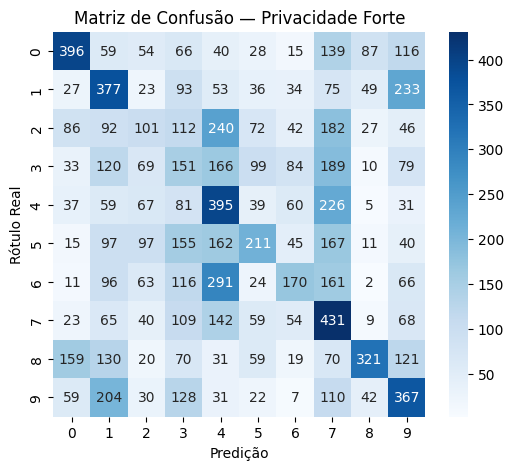

In [ ]:
for i, name in enumerate(history["cenario"]):
    plt.figure(figsize=(6,5))
    sns.heatmap(history["conf_matrix"][i], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusão — {name}")
    plt.xlabel("Predição")
    plt.ylabel("Rótulo Real")
    plt.show()


# **10) Gráfico do *trade-off* entre privacidade (ε) e acurácia final.**

Este trecho plota a relação entre o ε final e a acurácia alcançada em cada cenário, ilustrando visualmente o impacto direto da *privacy* na performance do modelo.


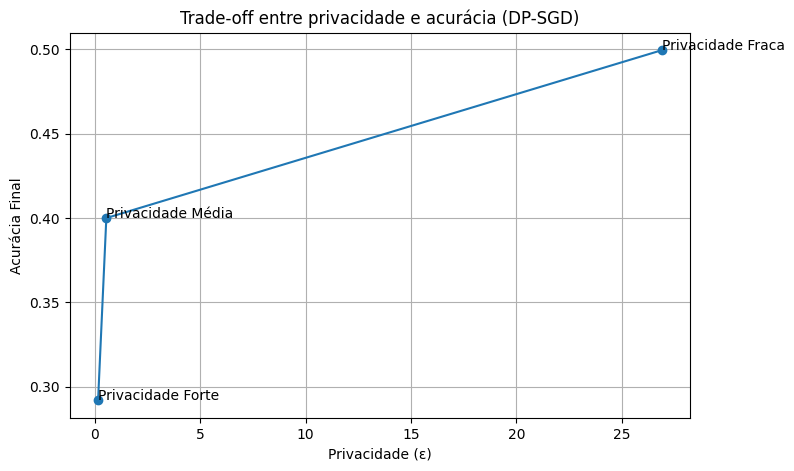

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_results["Epsilon_Final"], df_results["Acuracia_Final"], marker="o")

for i, row in df_results.iterrows():
    plt.text(row["Epsilon_Final"], row["Acuracia_Final"], row["Cenario"])

plt.xlabel("Privacidade (ε)")
plt.ylabel("Acurácia Final")
plt.title("Trade-off entre privacidade e acurácia (DP-SGD)")
plt.grid(True)
plt.show()


# **11) Relação entre o nível de ruído (σ) e a acurácia final.**

Este trecho mostra como o multiplicador de ruído afeta o desempenho final do modelo, evidenciando o impacto direto do ruído de *privacy* na acurácia.


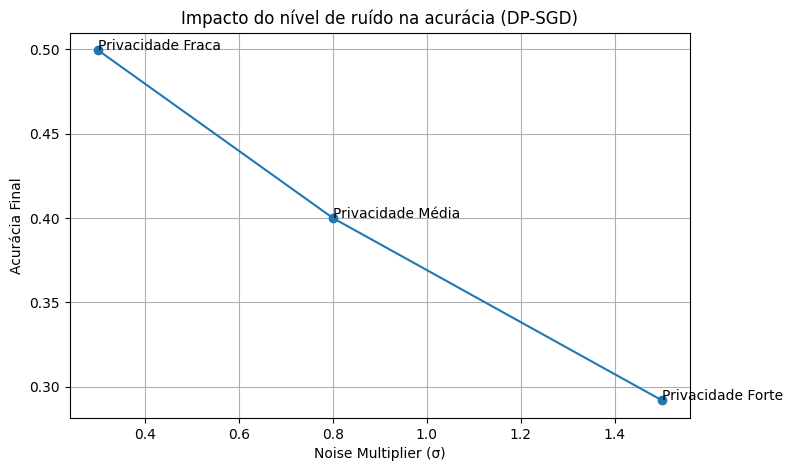

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df_results["NoiseMultiplier"], df_results["Acuracia_Final"], marker="o")

for i, row in df_results.iterrows():
    plt.text(row["NoiseMultiplier"], row["Acuracia_Final"], row["Cenario"])

plt.xlabel("Noise Multiplier (σ)")
plt.ylabel("Acurácia Final")
plt.title("Impacto do nível de ruído na acurácia (DP-SGD)")
plt.grid(True)
plt.show()


# **12) Relação entre o nível de ruído (σ) e o ε gasto.**

Este trecho plota como o multiplicador de ruído afeta o valor final de ε, mostrando a relação direta entre intensidade do ruído e o custo de *privacy*.


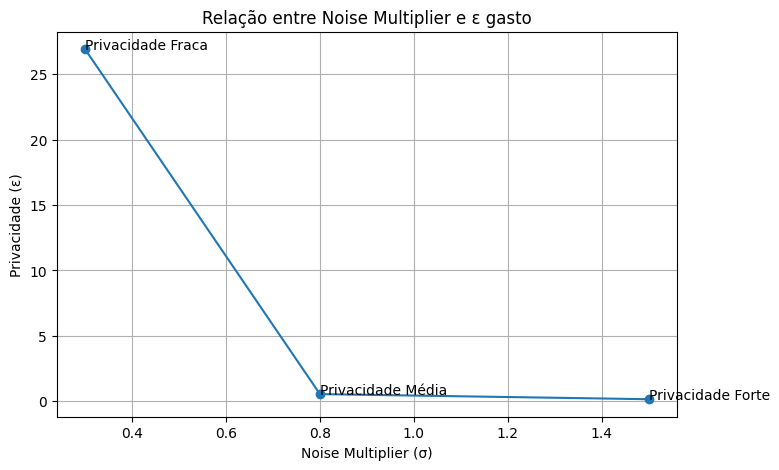

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df_results["NoiseMultiplier"], df_results["Epsilon_Final"], marker="o")

for i, row in df_results.iterrows():
    plt.text(row["NoiseMultiplier"], row["Epsilon_Final"], row["Cenario"])

plt.xlabel("Noise Multiplier (σ)")
plt.ylabel("Privacidade (ε)")
plt.title("Relação entre Noise Multiplier e ε gasto")
plt.grid(True)
plt.show()


# **13) Comparação da acurácia final entre os cenários de *privacy*.**

Este trecho gera um gráfico de barras mostrando a acurácia final obtida em cada nível de privacidade, permitindo comparação direta entre os cenários.


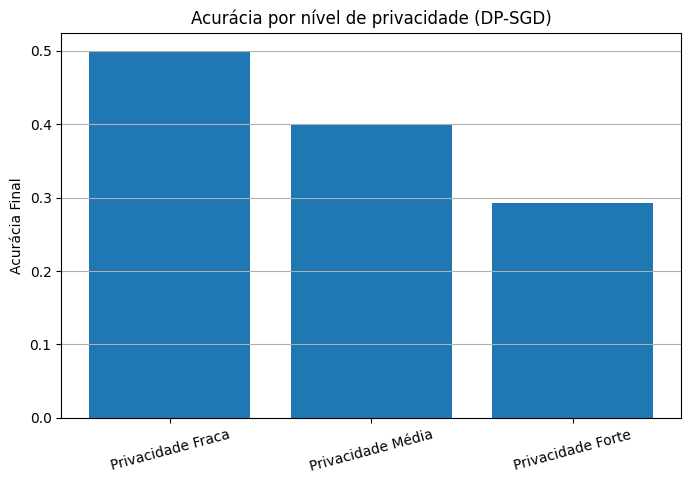

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(df_results["Cenario"], df_results["Acuracia_Final"])
plt.ylabel("Acurácia Final")
plt.title("Acurácia por nível de privacidade (DP-SGD)")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()


# **14) Comparação do ε consumido em cada cenário de *privacy*.**

Este trecho exibe um gráfico de barras com o valor final de ε para cada nível de privacidade, facilitando a análise do custo de *privacy* em cada configuração.


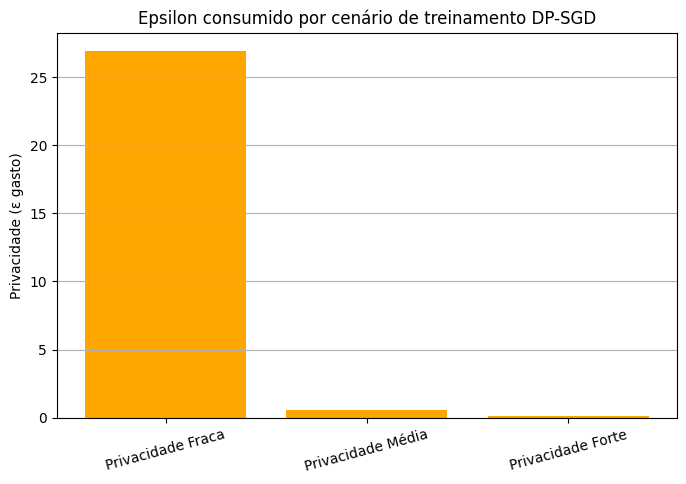

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(df_results["Cenario"], df_results["Epsilon_Final"], color="orange")
plt.ylabel("Privacidade (ε gasto)")
plt.title("Epsilon consumido por cenário de treinamento DP-SGD")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.show()


# **15) Visualização do impacto do par (ε, δ) na acurácia final.**

Este trecho plota a relação entre ε (fixando δ = 1e-5) e a acurácia final, destacando o efeito conjunto dos parâmetros de *privacy* na performance do modelo.


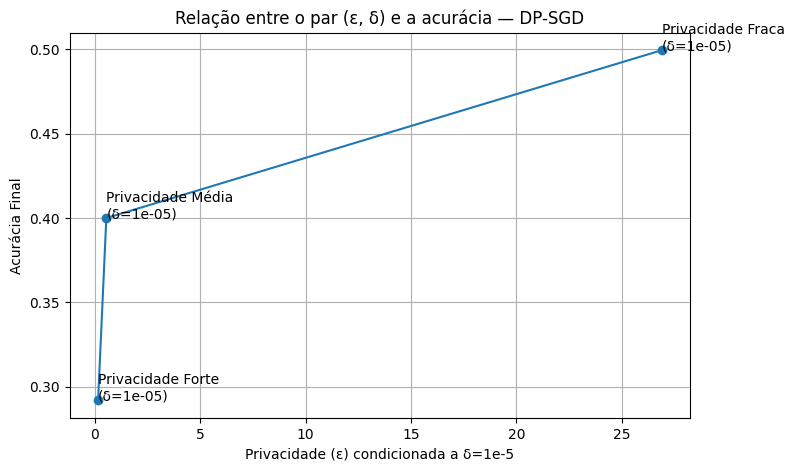

In [ ]:
import matplotlib.pyplot as plt

DELTA = 1e-5  # valor fixo do experimento

plt.figure(figsize=(8,5))
plt.plot(df_results["Epsilon_Final"], df_results["Acuracia_Final"], marker="o")

for i, row in df_results.iterrows():
    label = f"{row['Cenario']}\n(δ={DELTA})"
    plt.text(row["Epsilon_Final"], row["Acuracia_Final"], label)

plt.xlabel("Privacidade (ε) condicionada a δ=1e-5")
plt.ylabel("Acurácia Final")
plt.title("Relação entre o par (ε, δ) e a acurácia — DP-SGD")
plt.grid(True)
plt.show()


# **16) Evolução do *privacy budget* (ε acumulado) durante o treinamento.**

Este trecho mostra como o valor acumulado de ε cresce a cada época para cada cenário, ilustrando o consumo progressivo de *privacy* ao longo do treinamento com DP-SGD.


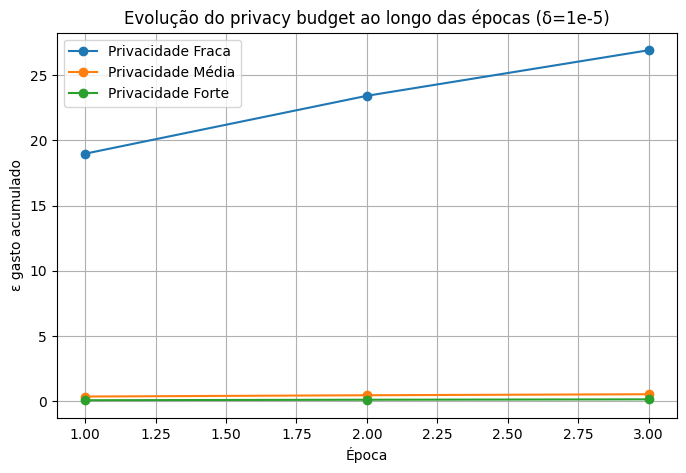

In [ ]:
plt.figure(figsize=(8,5))

for i, name in enumerate(history["cenario"]):
    eps_curve = history["epoch_eps"][i]
    plt.plot(range(1, len(eps_curve)+1), eps_curve, marker="o", label=name)

plt.xlabel("Época")
plt.ylabel("ε gasto acumulado")
plt.title("Evolução do privacy budget ao longo das épocas (δ=1e-5)")
plt.legend()
plt.grid(True)
plt.show()


# **17) Reconstrução manual do DataFrame final com métricas consolidadas.**

Este trecho recria manualmente o `DataFrame` contendo os três cenários de *privacy*, seus níveis de ruído, e as métricas finais de ε, acurácia e *loss*, permitindo análise direta sem depender do histórico anterior.


In [ ]:
import pandas as pd

df_results = pd.DataFrame({
    "Cenário": ['Privacidade Fraca', 'Privacidade Média', 'Privacidade Forte'],
    "Ruído Gaussiano (Multiplicador)": [0.3, 0.8, 1.5],
    "ε (épsilon) Final": [26.895783, 0.553284, 0.162141],
    "Acurácia Final": [0.4995,0.4000,0.2920],
    "Loss Final": [1.612989,1.947691,2.476144]
})

df_results




,Cenário,Ruído Gaussiano (Multiplicador),ε (épsilon) Final,Acurácia Final,Loss Final
0,Privacidade Fraca,0.3,26.895783,0.4995,1.612989
1,Privacidade Média,0.8,0.553284,0.4000,1.947691
2,Privacidade Forte,1.5,0.162141,0.2920,2.476144


# **18) Treinamento do modelo sem *privacy* para estabelecer o baseline.**

Este trecho define o ambiente de execução sem DP-SGD (seeds, dispositivo e função de avaliação), inicializa o modelo e o otimizar com SGD padrão, e treina por 3 épocas. São registradas as curvas de *loss* e acurácia, produzindo o desempenho de referência (baseline) sem qualquer mecanismo de privacidade.


In [5]:
import torch
import torch.nn as nn
import numpy as np

_sem_dp_seed = 123
torch.manual_seed(_sem_dp_seed)
torch.cuda.manual_seed_all(_sem_dp_seed)
np.random.seed(_sem_dp_seed)

_sem_dp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_sem_dp_device

def eval_sem_dp(model):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(_sem_dp_device), yb.to(_sem_dp_device)
            preds = model(xb).argmax(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    return correct / total

_sem_dp_epochs = 3
_sem_dp_lr = 0.1

_sem_dp_model = DPCNN().to(_sem_dp_device)
_sem_dp_optim = torch.optim.SGD(_sem_dp_model.parameters(), lr=_sem_dp_lr)

print("Modelo carregado para treino SEM DP.")

_sem_dp_losses = []
_sem_dp_accs = []

print("\nIniciando treinamento SEM PRIVACIDADE...\n")

for epoch in range(_sem_dp_epochs):

    _sem_dp_model.train()
    running_loss = 0
    count = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(_sem_dp_device), yb.to(_sem_dp_device)

        _sem_dp_optim.zero_grad()
        loss = nn.CrossEntropyLoss()(_sem_dp_model(xb), yb)
        loss.backward()
        _sem_dp_optim.step()

        running_loss += loss.item()
        count += 1

    avg_loss = running_loss / count
    acc = eval_sem_dp(_sem_dp_model)

    _sem_dp_losses.append(avg_loss)
    _sem_dp_accs.append(acc)

    print(f"Epoch {epoch+1}/{_sem_dp_epochs} | Loss={avg_loss:.4f} | Acc={acc:.4f}")

print("\nTreinamento SEM privacidade finalizado.")

print("\n================================================")
print("RESULTADO FINAL — TREINO SEM PRIVACIDADE")
print("================================================")
print(f"Acurácia final: {_sem_dp_accs[-1]:.4f}")
print(f"Perdas por época: {_sem_dp_losses}")
print(f"Acurácias por época: {_sem_dp_accs}")
print("================================================")


Modelo carregado para treino SEM DP.

Iniciando treinamento SEM PRIVACIDADE...

Epoch 1/3 | Loss=2.1762 | Acc=0.2491
Epoch 2/3 | Loss=1.7270 | Acc=0.4172
Epoch 3/3 | Loss=1.3467 | Acc=0.4960

Treinamento SEM privacidade finalizado.

RESULTADO FINAL — TREINO SEM PRIVACIDADE
Acurácia final: 0.4960
Perdas por época: [2.176160938294647, 1.7269734275310547, 1.346657396658607]
Acurácias por época: [0.2491, 0.4172, 0.496]
